## DABN13 - Assignment 5
In line with Lecture 7, Assignment 5 is somewhat more technical. This means there are no basic warm-up tasks since even the use of a canned routine for optimization requires us to write a function for our cost function.

Still, this assignment covers frequently occuring coding tasks in the context of function optimization. That is, you will write many functions, transfer a lot of mathematical expressions from the lecture slides into this script, create some simple plots and, most importantly, spend far too much time on trying to figure out what is wrong with your code. On the upside, this assignment gives you a little more freedom to write code in your own way. Enjoy!

### Preamble: Preparing the data

We are going to recycle a dataset on purchases in online shops that we already used in Assignment 2. 
Load the data into R and save it in an object called `shoppers`. The dataset is contained in a comma-separated spreadsheet. Accordingly, you will need to use the ´ read.csv()´ command in R.


In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

shoppers = pd.read_csv("online_shoppers_intention.csv")
np.random.seed(1)

In the steps below, we will fit a quite small logistic regression model including the following variables in addition to the intercept:

1. ` ExitRate ` without further transformation
2. The (natural) logarithm of ` ProductRelated_Duration + 1 `

The code below does all data transformations for you. However, please note the shortened variable names that we are going to use from now on.

In [127]:
shoppers = shoppers.rename(columns={"ExitRates": "ER"})
shoppers["lPR_Dur"] = np.log(shoppers["ProductRelated_Duration"] +1)
shoppers["constant"] = 1
X        = np.asarray(shoppers[["constant", "ER", "lPR_Dur"]])

y        = np.ones((X.shape[0],1))
y[shoppers["Revenue"]==False] = -1

## Part 1: Learning logistic regression without `sklearn`

### Task 1a)

If we want to learn a logistic regression manually, we need to specify the cost function that we are going to minimize So as a first step, create a function `cost_logistic_1a()` whose inputs are 

1. `theta`: a one-dimensional NumPy array of coefficients,
2. `y`: a $n \times 1$ NumPy array of outputs,
3. `X`: a $n \times p$ NumPy array of inputs.

The function is then supposed to return the cost on the data consisting of `y` and `X` with logistic loss and coefficient vector values `theta`.


In [128]:
def cost_logistic_1a(theta, y, X):
    n = len(y)
    total_loss = 0
    for i in range(0, n):
        loss = np.log(1 + np.exp(np.dot(-y[i]*theta.T, X[i])))
        total_loss += loss
    cost = (1/n) * total_loss
    return(cost)

### Task 1b) 

As a next step, we need a function that returns the gradient of the cost function. Write such a function `grad_logistic_1b()` that takes the same arguments as `cost_logistic()` and which returns a one-dimensional NumPy array (with $p$ elements) containing the gradient of our cost function.

In [129]:
def grad_logistic_1b(theta, y, X):
    n = len(y)
    total = np.zeros(len(theta))
    for i in range(0, n):
        part = (-y[i] * X[i]) / (1 + np.exp(y[i]*np.dot(X[i], theta)))
        total += part
    gradient = (1/n) * total
    return(gradient)

### Task 1c)

A canned routine for optimization is provided in the SciPy package: The `minimize()` function. `minimize()` minimizes a function that you feed into it. It also allows you to provide a gradient function to speed up optimization and to achieve better numerical stability in complicated cases. 

The function minimized by `minimize()` should have only one argument: The parameters of our minimization problem. This does not really fit the structure of `cost_logistic_1a` and `grad_logistic_1b` which have three arguments each. However, the last two arguments specify the data that we use. Therefore we make a short detour to arrive at functions of one argument only.

1. Create a [lambda function](https://docs.python.org/3/reference/expressions.html#lambdas) `cost_logistic_1c` which takes `theta` as its only input and which calls `cost_logistic_1a` from Task 1a with `theta` as well as  the previosly created output `y` and inputs `X`.
2. In the same fashion, create a lambda function `grad_logistic_1c` that turns `grad_logistic_1b` into a function with one single argument `theta` as well as `y` and `X` as (fixed) output and inputs, respectively.



In [130]:
cost_logistic_1c = lambda theta: cost_logistic_1a(theta, y, X)
grad_logistic_1c = lambda theta: grad_logistic_1b(theta, y, X)

### Task 1d)
The`minimize()`-function allows you to choose from several algorithms from the very broad literature on optimization methods. We are going to use the `BFGS` method which is a very popular modification of Newton's method. 

Now use `minimize()` to minimize `cost_logistic_1c` on your training data. Follow the instructions below:

1. Let all initial coefficient values be zero.
2. Choose the BFGS minimization method.
3. Supply your gradient function `grad_logistic_1c` as well. If you could not solve Task 1b, leave out the gradient. 
4. Use the desired tolerance level `tol_1d` as the tolerance argument.

Save the resulting list object as `optim_result_1d`.

In [118]:
from scipy.optimize import minimize

tol_1d = 1e-9

optim_result_1d  = minimize(cost_logistic_1c,x0=np.zeros(X.shape[1]), method='BFGS', 
                            jac=grad_logistic_1c, tol=tol_1d)

print(optim_result_1d)

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 0.38688976841366296
        x: [-2.489e+00 -3.028e+01  2.474e-01]
      nit: 35
      jac: [ 3.490e-09  5.541e-11  2.622e-08]
 hess_inv: [[ 3.440e+02 -1.397e+03 -4.490e+01]
            [-1.397e+03  3.550e+04  9.731e+01]
            [-4.490e+01  9.731e+01  6.273e+00]]
     nfev: 92
     njev: 82


### Task 1e)

Have a closer look at the OptimizeResult object `optim_result_1d`. What do its different components tell us about our solved minimization problem? Explain this in your *own* words by writing explanations into the four string variables below.

In [131]:
whatis_x_1d       = "x are the are estimated thetas/parameters" 
whatis_fun_1d     = "fun is the value of our cost function at when using our estimated coefficients"
whatis_nit_1d     = "nit is the number of iterations performed by the algorithm"
whatis_success_1d = "success being false indicates that we didn't reach our tolerance level, so there is something not\
    working perfectly here. Therefore, our estimated parameters are probably not at the minimum."

## Part 2: Gradient descent manually

In this part, you are going to write your own routine for gradient descent.

### Task 2a)

Below, I have prepared a fragment of a function that is supposed to conduct gradient descent. This function, `grad_desc`, takes the following inputs:

- `par`: initial coefficient values as one-dimensional NumPy array
- `fn`: The objective function
- `gr`: The gradient of the objective function
- `stepsize`: The step size 
- `maxitr`: The maximum number of parameter updates. Default is set to 5000.
- `tol`: The tolerance for coefficient updates to be considered "effectively 0". Default is set to 0.000001
-  `y`: an $n \times 1$ NumPy array of outputs
-  `X`: an $n \times p$ NumPy array of inputs.

Additionally, the function already contains the following objects:

- `coef_path`: A two-dimensional NumPy array whose columns eventually contain the entire sequence of coefficient vectors,
- `coef_upd`: A two-dimensional NumPy array whose columns eventually contain the entire sequence of coefficient updates,
- `fn_path`: A one-dimensional NumPy array that eventually contains all values of the objective function.

Your task is to write code that conducts the coefficient updates of gradient descent until the Euclidean norm of a coefficient update is below the tolerance level `tol`. 

The full sequence of coefficient vectors, coefficient updates and function values should be saved in the objects `coef_path`, `coef_upd` and `fn_path`, respectively. Maximally `maxitr` coefficient updates should be made (fewer if coefficient updates are below tolerance).

In [132]:
def grad_desc(par, fn, gr, stepsize, maxitr=5000, tol=1e-6, y=None, X=None):

    # Don't change anything here
    coef_path = par[:,None]
    coef_upd  = np.empty((len(par), 0))
    fn_path   = [fn(theta=par, X=X, y=y)]
    
    # Start writing stuff here
    
    i=0
    while i < maxitr:
        gradient = gr(theta=par, y=y, X=X)
        par = par - stepsize*gradient
        coef_path = np.append(coef_path, par[:, None], axis=1)
        coef_upd =  np.append(coef_upd, stepsize * gradient[:, None], axis=1)
        fn_path.append(fn(theta=par, X=X, y=y))
        euc_norm = np.linalg.norm(coef_upd[-1])
        i += 1
        if np.linalg.norm(coef_upd[-1]) < 0:
            break
    itr = i
    # Don't change anything here
    return {
        'coef_final': coef_path[:,-1],
        'itr': itr,
        'coef_path': coef_path,
        'updates': coef_upd,
        'fun_path': fn_path
    }


### Task 2b)

Now we tune the step size of gradient descent. In order to do this, write a function `plot_cost_2b` which runs gradient descent with a chosen step size and only 100 coefficient updates. The function should then create an object containing a line plot of the number of coefficient updates against the cost at the specific update. 

I have already prepared a dictionary object `gd_ctrl_2b` for you that contains the gradient descent function as well as most inputs to this function. Use `gd_ctrl_2b` as an input and define further arguments to your step size as well as the data.

Once you have created `plot_cost_2b`, play around with different step sizes. Save a plot with a step size that you deem as too low (high) as object `plot_tooLO_2b` (`plot_tooHI_2b`). Save another plot `plot_decent_2b` which contains the development of cost with a good step size.

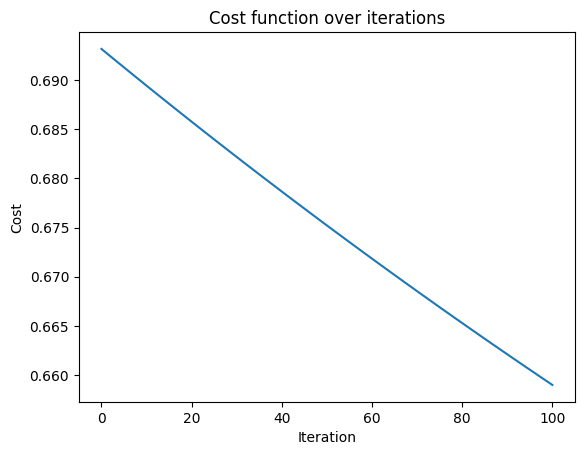

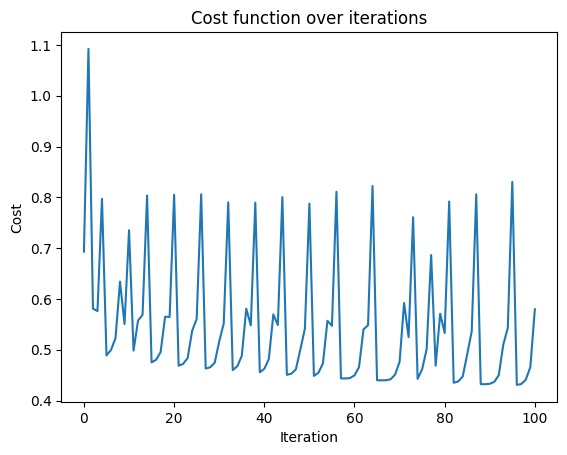

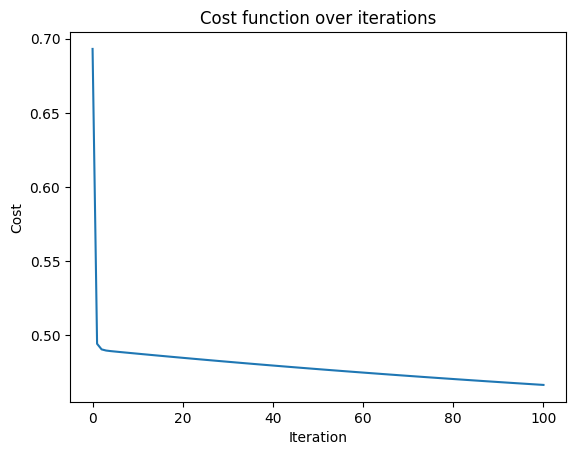

In [133]:
gd_ctrl_2b = {
    'par': np.array([0, 0, 0]),
    'fn': cost_logistic_1a,
    'gr': grad_logistic_1b,
    'gd_fun': grad_desc,
    'maxitr': 100
}

def plot_cost_2b(gd, stepsize = None, y=y, X=X):
    cost = gd['gd_fun'](
        par = gd['par'], 
        fn = gd['fn'], 
        gr = gd['gr'], 
        stepsize = stepsize, 
        maxitr = gd['maxitr'], 
        y = y, 
        X = X
        )
    plt.plot(np.arange(cost['itr']+1), cost['fun_path'])
    plt.xlabel('Iteration')
    plt.ylabel('Cost')
    plt.title('Cost function over iterations')
    plt.show()


# Step size too low:
plot_tooLO_2b = plot_cost_2b(gd_ctrl_2b, stepsize = 0.0001)
# Step size too high:
plot_tooLO_2b = plot_cost_2b(gd_ctrl_2b, stepsize = 0.5)
# Steo size quite ok:
plot_tooLO_2b = plot_cost_2b(gd_ctrl_2b, stepsize = 0.1)

### Task 2c)

Use the string variable `stepsize_motivate_2c` to motivate why you chose the three step size examples in Task 2b. More specifically, explain what lead you to the conclusion that a step size is too low or too high.

In [123]:
stepsize_motivate_2c = "For the first plot where the step size is too low, we see that the each iteration does\
     not change the coefficient value by much, so we need many iterations in order for us to arrive at the optimal \
        coefficient value. For the too high case, we see the zig-zag pattern caused by the high step size, \
            which means that the step size is too high and we are not able to converge to the optimal coefficient value. \
                For the last plot, we see that the step size is quite ok, since we are able to converge to the optimal \
                    coefficient value in a reasonable number of iterations. Also for the last plot, we see that the \
                        largest step is done during the first iteration, which is optimal since we want to take large \
                            steps in the beginning and then smaller steps as we get closer to the optimal coefficient value."

### Task 2d)

Use `grad_desc` with your chosen step size to learn the coefficients of the logistic regression model that we have been working with so far. Keep the maximum number of updates at its default value. Save the resulting obect as `gd_result_2d`. 

Does gradient descent stop before the maximum number of updates? If not, how far does gradient descent get the cost function towards the value achieved by `optim()` in Task 1c? Write your answer into the string variable `gd_conclusion_2d`

In [124]:
gd_result_2d = grad_desc(par=np.array([0, 0, 0]), fn=cost_logistic_1a, gr=grad_logistic_1b, stepsize=0.1, y=y, X=X)

gd_conclusion_2d = "It does not, it performs all 5000 iterations. It gets the cost down to 0.414, while in 1c it goes to\
    0.387"

## Part 3: Newton's method manually

Given that you have implemented gradient descent in Part 2, you have already done most of the hard work that is required for Newton's method. After all, the only thing that differs is the expression for your coefficient update. For this reason, we will work on our own routine for Newton's method.

### Task 3a)
Newton's method is more demanding than gradient descent in that it requires us to obtain the Hessian of our objective function for any desired vector of coefficients. Write such as function `hessian_logistic_3a` which has the same arguments as `grad_logistic_1b` and which returns the hessian of your cost function with logistic loss.

In [137]:
def hessian_logistic_3a(theta, y, X):
    n = len(y)
    p = len(theta)
    total = np.zeros((p, p))
    for i in range(0, n):
        z = y[i]*np.dot(theta, X[i])
        exp = np.exp(z)
        division = (np.square(y[i])*exp)/np.square(1+exp)
        term = np.outer(X[i], X[i]) * division
        total = total + term
    return(total/n)



### Task 3b)

Modify `grad_desc` to turn it into a function for Newton's method. This only requires you to remove step size from the function arguments, to add a new argument for the Hessian and to change the line for your coefficient update. Save your function as object `newton_3b`.

In [138]:
def newton_3b(par, fn, gr, hes, maxitr=5000, tol=1e-6, y=None, X=None):

    # Don't change anything here
    coef_path = par[:,None]
    coef_upd  = np.empty((len(par), 0))
    fn_path   = [fn(theta=par, X=X, y=y)]
    
    # Start writing stuff here
    
    i=0
    while i < maxitr:
        gradient = gr(theta=par, y=y, X=X)
        inv_hes = np.linalg.inv(hes(theta = par, y=y, X=X))
        update = -np.dot(inv_hes, gradient)
        par = par + update
        coef_path = np.append(coef_path, par[:, None], axis=1)
        coef_upd =  np.append(coef_upd, update[:, None], axis=1)
        fn_path.append(fn(theta=par, X=X, y=y))
        euc_norm = np.linalg.norm(coef_upd[-1])
        i += 1
        if np.linalg.norm(coef_upd[-1]) < 0:
            break
    itr = i
    # Don't change anything here
    return {
        'coef_final': coef_path[:,-1],
        'itr': itr,
        'coef_path': coef_path,
        'updates': coef_upd,
        'fun_path': fn_path
    }


### Task 3c)

Use your function `newton_3b` to learn the logistic regression model that you already learned in Tasks 1c and 2d. Keep the maximum number of updates at its default value. Save the resulting obect as `nm_result_3c`. 

Does Newton's method stop before the maximum number of updates? If not, how far does gradient descent get the cost function towards the value achieved by `optim()` in Task 1c? What is your verdict about the performance of Newton's method relative to gradient descent and the `optim()` command in the case of logistic regression? Write your answer into the string variable `nm_conclusion_3c`.

In [145]:
nm_result_3c = newton_3b(par=np.array([0, 0, 0]), fn=cost_logistic_1a, gr=grad_logistic_1b, hes=hessian_logistic_3a, y=y, X=X)
print(nm_result_3c)
nm_conclusion_3c = "First of all. Both of these seem to be extremely computationally heavy. It took us 16 minutes\
to estimate the gradient descent one and 26(!) for the newton method. There must be a way\
to use vectorized operations, but we simply calculate it as the formula from the lecture says. With that being said\
the Newton method did not converge either, and used all 5000 iterations. We got  0.3868897684136664 though so\
it outperformed the gradient descent with stepsize set to 0.1. And it was basically neck-to-neck with the\
minimize-function. The difference was far down in the decimals. Conclusion: We would never ever code this manually ever again."

{'coef_final': array([ -2.48931966, -30.28156662,   0.24744927]), 'itr': 5000, 'coef_path': array([[  0.        ,  -1.63117423,  -2.18887308, ...,  -2.48931966,
         -2.48931966,  -2.48931966],
       [  0.        ,  -3.87818635, -10.53039676, ..., -30.28156662,
        -30.28156662, -30.28156662],
       [  0.        ,   0.06996975,   0.14623519, ...,   0.24744927,
          0.24744927,   0.24744927]]), 'updates': array([[-1.63117423e+00, -5.57698857e-01, -2.29089921e-01, ...,
        -5.34114270e-15,  4.42736029e-15, -6.27617907e-16],
       [-3.87818635e+00, -6.65221040e+00, -9.95187113e+00, ...,
         1.10025430e-14, -1.62826275e-14,  2.88213853e-15],
       [ 6.99697493e-02,  7.62654394e-02,  6.44467556e-02, ...,
         7.31574917e-16, -5.81268495e-16,  8.12584547e-17]]), 'fun_path': [0.6931471805600665, 0.4203187761766812, 0.3974879701242572, 0.38886996623683845, 0.3869695927622982, 0.3868899154662944, 0.3868897684141846, 0.3868897684136662, 0.3868897684136667, 0.3868897